# Basic data preprocessing 
### load raw files -> generate clips -> compute features-> aggregate into a matrix of features and scores
** Pandas version required to load pickle files is 0.20.1 or greater **

* Try classifying symptom presence from "typing", "walking" and "finger-to-nose" 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt

# from PreprocessFcns import gen_clips, powerspectra

%matplotlib inline

In [2]:
#---Pandas version required to load pickle files is 0.20.1 or greater---
pd.__version__

'0.20.3'

In [3]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
# path = '/Volumes/RT&O/CIS-PD Study/Subjects/' #Mac
path = r'W:\CIS-PD Study\Subjects' #Windows local path adai
#---------------------------------------------------------------------------------------------------------
#Path where dictionary subject data is stored
# dict_path = 'W:\CIS-PD Study\Data_dict' #remote repo
# dict_path = '../Data_dict' #local path
dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

scores_path = r'W:\CIS-PD Study\Scores' #remote repo
#scores_path = '../Scores/' #local path


In [4]:
complete = list(['Heart Rate Variability', 'MDS-UPDRS #1: Finger Tapping',
           'MDS-UPDRS #2: Hand Movements', 'MDS-UPDRS #3: Pronation-Supination',
           'MDS-UPDRS #4: Toe Tapping', 'MDS-UPDRS #5: Leg Agility',
           'MDS-UPDRS #6: Arising from Chair', 'MDS-UPDRS #7: Gait',
           'MDS-UPDRS #8: Postural Stability', 'MDS-UPDRS #9: Postural Hand Tremor',
           'MDS-UPDRS #10: Kinetic Hand Tremor', 'MDS-UPDRS #11: Rest Tremor',
           'Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
           'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
           'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
           'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
           'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
           'Motor #12: Folding Towels', 'Motor #13: Sitting'])


def process_annotations(path):
#def process_annotations(path, SubID):
#---------------------------------------------------------------------------------------------------------
# Processes raw annotations file to extract start / end timestamps and remove unnecessary data
#
# Inputs:  path - filepath of the subject folder containing annotations.csv
#
# Outputs: df - dataframe containing list of activities and their start / end timestamps
#---------------------------------------------------------------------------------------------------------
    df = pd.read_csv(os.path.join(path, 'annotations.csv'))
    del df['Timestamp (ms)']
    del df['AnnotationId']
    del df['AuthorId']
    
    testInfo = df[df.EventType == 'Testing Day'].dropna(how='any', axis=0)
    testInfo['Start Timestamp (ms)'] = pd.to_datetime(testInfo['Start Timestamp (ms)'], unit='ms', utc=True).dt.tz_localize('UTC').dt.tz_convert('US/Central')
    del testInfo['Stop Timestamp (ms)']
    del testInfo['EventType']
    del df['Value']
    
    testInfo = testInfo.rename(columns = {'Value':'Day', 'Start Timestamp (ms)':'Date'}).reset_index(drop=True)
    testInfo['Date'] = testInfo['Date'].dt.date
    
    df = df[(df.EventType != 'Testing Day')]
    
    sorter = set(df.EventType.unique().flatten())
    sorterIndex = dict(zip(sorter, range(len(sorter))))
        
    df['EventType_Rank'] = df['EventType'].map(sorterIndex)
    df['Cycle'] = df.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    del df['EventType_Rank']
    df[df['EventType'].str.contains('Heart')] = df[df['EventType'].str.contains('Heart')].replace(to_replace={'Cycle': {1: 'NaN', 2: 'NaN', 3: 'NaN', 4: 'NaN'}})
    df = df.reset_index(drop=True).set_index('EventType')
    
    # return d1_df, d2_df, df
    return df, testInfo

## Helper fcns

In [5]:
def extract_data(SubID, path):
#---------------------------------------------------------------------------------------------------------
# For a given subject, extracts and separates accelerometer, gyroscope, and EMG/ECG data into trials and sensor per activity
#
# Inputs: SubID - string of numbers corresponding to the subject ID
#         path - system path to corresponding subject's raw data files
#
# Outputs: act_dict - dictionary of both MDS-UPDRS and Motor Assessment activities separated by trial, sensor location, and
#                     accelerometer + gyroscope or accelerometer + EMG/ECG data. Every key within this dictionary is a dictionary
#---------------------------------------------------------------------------------------------------------
    #timestamps = process_annotations(path, SubID)
    timestamps, testInfo = process_annotations(path)
    
    # Creates list of sensor locations from folders within subject's raw data directory
    locations = [locs for locs in os.listdir(path) if os.path.isdir(os.path.join(path, locs))]
    
    # Creates dictionary of empty dataframes to merge all accelerometer, gyroscope, and EMG/ECG data for each sensor
    accel = {locs: pd.DataFrame() for locs in locations}
    gyro = {locs: pd.DataFrame() for locs in locations}
    elec = {locs: pd.DataFrame() for locs in locations}
    
    # Finds and merges all accelerometer, gyroscope, and EMG/ECG data for each sensor, retains datetime information
    for root, dirs, files in os.walk(path, topdown=True):
        for filenames in files:
            if filenames.endswith('accel.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                print(location)
                accel[location] = accel[location].append(temp_df)

            elif filenames.endswith('gyro.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                gyro[location] = gyro[location].append(temp_df)

            elif filenames.endswith(('elec.csv', 'emg.csv', 'ecg.csv', 'ekg.csv')):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                elec[location] = elec[location].append(temp_df)
                
    # Complete dictionary of all activities
    act_dict = {acts: pd.DataFrame() for acts in complete}

    # Populate dictionary keys per activity with every iteration / trial
    for activities in complete:
        
        startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)'].values
        endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)'].values

        # Create trial dictionary with each key containing all sensor data related with each activity's trial
        trial_dict = {trials: pd.DataFrame() for trials in range(0, len(startTimestamp))}

        # Populate trial directory keys
        for trials in range(0, len(startTimestamp)):

            startTime = startTimestamp[trials]
            endTime = endTimestamp[trials]

            # Create sensor location dictionary with each key corresponding to sensor locations
            sensor_dict = {locs: pd.DataFrame() for locs in locations}

            # Extract sensor data and populate sensor_dict with sensor data
            for location in locations:

                data = {'accel': pd.DataFrame(), 'gyro': pd.DataFrame(), 'elec': pd.DataFrame()}

                if not accel[location].empty:
                    accelData = accel[location]
                    data['accel'] = accelData[(accelData.index >= startTime) & (accelData.index <= endTime)]

                if not gyro[location].empty:
                    gyroData = gyro[location]
                    data['gyro'] = gyroData[(gyroData.index >= startTime) & (gyroData.index <= endTime)]

                if not elec[location].empty:
                    elecData = elec[location]
                    data['elec'] = elecData[(elecData.index >= startTime) & (elecData.index <= endTime)]

                sensor_dict[location] = data

            trial_dict[trials] = sensor_dict

        act_dict[activities] = trial_dict
    
    return act_dict, timestamps, testInfo


                                
def plot_data(acts, activity, trial, sensor, data, start=0, end=100000):
#---------------------------------------------------------------------------------------------------------
# Plots requested data
# 
# Inputs: acts - activity dataframe containing all sensor data from one subject
#         activity - desired activity to plot
#         trial - desired trial number to plot
#         sensor - desired sensor (serial number or name of location) to analyze
#         data - desired type of data to analyze (accel, gyro, EMG/ECG)
#         start - starting index, default starts at first point
#         end - ending index, default is 500th data point
#---------------------------------------------------------------------------------------------------------
    toPlot = pd.DataFrame(acts[activity][trial]).loc[data, sensor][start:end].plot(figsize=(6,4))
    

#extract clips for accelerometer and gyro data
def gen_clips(act_dict,task,location,clipsize=5000,overlap=0,verbose=False):
    
    clip_data = {} #the dictionary with clips
    #params
    len_tol = 0.8   #% of the intended clipsize below which clip is not used

    for trial in act_dict[task].keys():
        clip_data[trial] = {}            

        for s in ['accel','gyro']:

            if verbose:
                print(task,' sensortype = %s - trial %d'%(s,trial))
            #create clips and store in a list
            rawdata = act_dict[task][trial][location][s]
            #reindex time (relative to start)
            idx = rawdata.index
            idx = idx-idx[0]
            rawdata.index = idx
            #create clips data
            deltat = np.median(np.diff(rawdata.index))
            idx = np.arange(0,rawdata.index[-1],clipsize*(1-overlap))
            clips = []
            for i in idx:
                c = rawdata[(rawdata.index>=i) & (rawdata.index<i+clipsize)]
                if len(c) > 0.8*int(clipsize/deltat): #discard clips whose length is less than len_tol% of the window size
                    clips.append(c)
            clip_len = [clips[c].index[-1]-clips[c].index[0] for c in range(len(clips))] #store the length of each clip
            #assemble in dict
            clip_data[trial][s] = {'data':clips, 'clip_len':clip_len}

    return clip_data


#returns power spectra of the signal over each channel between min and max freq at given resolution (nbins)
#returns the labels for each bin
#if binavg is True it averages the PSD within bins to reduce PSD noise
def powerspectra(x,fm,fM,nbins=10,relative=False,binavg=True):
    
    #feature labels
    labels=[]
    s = np.linspace(fm,fM,nbins)
    lax = ['X','Y','Z']
    for l in lax:
        for i in s:
            labels.append('fft'+l+str(int(i)))
            
    #signal features
    n = len(x) #number of samples in clip
    Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
    timestep = 1/Fs 
    freq = np.fft.fftfreq(n,d=timestep) #frequency bins

    #run FFT on each channel 
    Xf = x.apply(np.fft.fft)
    Xf.index = np.round(freq,decimals=1) #reindex w frequency bin
    Pxx = Xf.apply(np.abs)
    Pxx = Pxx**2 #power spectra
    if relative:
        Pxx = Pxx/np.sum(Pxx,axis=0) #power relative to total
    
    #power spectra between fm-fM Hz
    bin1 = int(timestep*n*fm)
    bin2 = int(timestep*n*fM)
    bins = np.linspace(bin1,bin2,nbins,dtype=int)
#     print(bins/(round(timestep*n)))

    #average power spectra within bins
    if binavg:
        deltab = int(0.5*np.diff(bins)[0]) #half the size of a bin (in samples)
        Pxxm = []
        for i in bins:
            start = int(max(i-deltab,bins[0]))
            end = int(min(i+deltab,bins[-1]))
            Pxxm.append(np.mean(Pxx.iloc[start:end,:].values,axis=0))            
        Pxxm = np.asarray(Pxxm)
        Pxx = pd.DataFrame(data=Pxxm,index=Pxx.index[bins],columns=Pxx.columns)
        return Pxx, labels
    
    else:
        return Pxx.iloc[bins,:], labels


#extract features from both sensors (accel and gyro) for current clips and trials
#input: dictionary of clips from each subject
#output: feature matrix from all clips from given subject and scores for each clip
def feature_extraction(clip_data):
    
    features_list = ['EX','EY','EZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
                    'skewX','skewY','skewZ','kurtX','kurtY','kurtZ']
    
    for trial in clip_data.keys():

        for sensor in clip_data[trial].keys():

            #cycle through all clips for current trial and save dataframe of features for current trial and sensor
            features = []
            for c in range(len(clip_data[trial][sensor]['data'])):
                rawdata = clip_data[trial][sensor]['data'][c]
#                 print(rawdata.head(3))
                
                #extract features on current clip
                
                #Energy of signal on each axis
                E = np.asarray(np.sum(rawdata**2,axis=0))
                
                #range on each axis
                min_xyz = np.min(rawdata,axis=0)
                max_xyz = np.max(rawdata,axis=0)
                r = np.asarray(max_xyz-min_xyz)
            
                #Moments on each axis
                mean = np.asarray(np.mean(rawdata,axis=0))
                var = np.asarray(np.std(rawdata,axis=0))
                sk = skew(rawdata)
                kurt = kurtosis(rawdata)
                
                #Power of FFT between 1-10 Hz
                Pxx,fft_labels = powerspectra(rawdata,1,10) #dataframe with power spectra for each axis
                xfft = np.asarray([Pxx.iloc[:,0].values, Pxx.iloc[:,1].values, Pxx.iloc[:,2].values])
                xfft = np.reshape(xfft,(1,xfft.size)) #row vector
                xfft = xfft.reshape(-1)

                #Assemble features in array
                x = np.concatenate((E,r,mean,var,sk,kurt,xfft))
#                 x = np.asarray([E,r,mean,var,sk,kurt,xfft]) #features for 1 clip
#                 x = np.reshape(x,(1,x.size)) #row vector
                features.append(x)
                    
            F = np.asarray(features) #feature matrix for all clips from current trial
            F = F.squeeze()            
            clip_data[trial][sensor]['features'] = pd.DataFrame(data=F,columns=features_list+fft_labels,dtype='float32')  
        
#     return clip_data #not necessary


#highpass filter data to remove gravity (offset - limb orientation) from accelerometer data from each visit (trial)
#input: Activity dictionary, cutoff freq [Hz], task and sensor location to filter
def HPfilter(act_dict,task,loc,cutoff=0.75):

    sensor = 'accel'
    for trial in act_dict[task].keys():
        rawdata = act_dict[task][trial][loc][sensor]
        idx = rawdata.index
        idx = idx-idx[0]
        rawdata.index = idx
        x = rawdata.values 
        Fs = np.mean(1/(np.diff(rawdata.index)/1000)) #sampling rate    
        #filter design
        cutoff_norm = cutoff/(0.5*Fs)
        b,a = butter(4,cutoff_norm,btype='highpass',analog=False)
        #filter data
        xfilt = filtfilt(b,a,x,axis=0)
        rawdatafilt = pd.DataFrame(data=xfilt,index=rawdata.index,columns=rawdata.columns)
        act_dict[task][trial][loc][sensor] = rawdatafilt


# Fix Error Functions

In [6]:
def fix_errors(participant):
#input: 4 digit participant ID
#Output: ErrorList - A list of the errors needed to be fixed for the participant
#        timestamps - The dataFrame with the errors corrected for the participant
#        errordf - The dataFrame containing the remaining errors less the ones just fixed

   # errordf = pd.read_excel(r'C:\Users\Alex\OneDrive\SRALAB\PD\PD_errorWorkbook.xlsx')
    errordf = pd.read_excel(r'X:\CIS-PD Study\PD_errorWorkbook.xlsx')
    errPar = errordf[errordf['Participant'] == participant]
   # fixdf = pd.read_excel(r'C:\Users\Alex\OneDrive\SRALAB\PD\PD_fixedErrors.xlsx')
    #fixdf = pd.read_excel(r'C:\Users\aboe.SMPP\OneDrive\SRALAB\PD\PD_fixedErrors.xlsx')
    errorActivity = (errPar['Activity'])
    error = errPar['Error']
    cycle = errPar['Cycle']
    day = errPar['Day']
    time = errPar['Time Adjusted (sec)']
    desc = errPar['Type']
    errorAndActivity = errPar[['Error','Activity']]
    path = r'X:\CIS-PD Study\Subjects\1016'
    timestamps = process_annotations(path)
    
    print('There are',str(len(error)),'errors to be fixed:\n')
    print(errorAndActivity)
    
    for a in range(0,len(error)):
        errAct = (errorActivity.iloc[a])
        errType = (error.iloc[a])
        errCycle = (cycle.iloc[a])
        errTime = (time.iloc[a])
        errDesc = (desc.iloc[a])
        errDay = (day.iloc[a])

        if errType == 'Merge':
            timestamps = fix_merge(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Late':
            timestamps = fix_late(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Early':
            timestamps = fix_early(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Duplicate':
            timestamps = fix_duplicate(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Split':
            timestamps = fix_split(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)
            
        elif errType == 'Absent':
            ;
            
    for a in range(0,len(error)):
        errAct = (errorActivity.iloc[a])
        errType = (error.iloc[a])
        errCycle = (cycle.iloc[a])
        errTime = (time.iloc[a])
        errDesc = (desc.iloc[a])
        errDay = (day.iloc[a])
        
        if errType == 'Absent':
            timestamps = fix_absent(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)
            
    tempappend = errordf.loc[errPar.index.values]
    #fixdf = fixdf.append(tempappend)
    errordf = errordf.drop(errPar.index.values)
    
   # timestamps.to_excel(r'C:\Users\Alex\OneDrive\SRALAB\PD\timestamps_corrected.xlsx')
    #timestamps.to_excel(r'C:\Users\aboe.SMPP\OneDrive\SRALAB\PD\timestamps_corrected.xlsx')
    #errordf.to_excel(r'C:\Users\Alex\OneDrive\SRALAB\PD\PD_errorWorkbook.xlsx')
   # fixdf.to_excel(r'C:\Users\Alex\OneDrive\SRALAB\PD\PD_fixedErrors.xlsx')
    #fixdf.to_excel(r'C:\Users\aboe.SMPP\OneDrive\SRALAB\PD\PD_fixedErrors.xlsx')

    return timestamps


def fix_late(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
# subtracts time from the beginning or ending timestamp of the designated activity

    for i in range(0,len(timestamps)-1):
        startRow = timestamps.iloc[i]
        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            errorLocation = i
      
            if errType == 'End':
                startTime = startRow['Stop Timestamp (ms)']
                startTime = startTime - (errTime*1000)
                ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
                timestamps.set_value(i,ii,startTime,takeable=True)    
        
            else:
                startTime = startRow['Start Timestamp (ms)']
                print(startRow)
                print(startTime)
                startTime = startTime - (errTime*1000)
                print(errTime)
                print(startTime)
                ii = timestamps.columns.get_loc('Start Timestamp (ms)')
                timestamps.set_value(i,ii,startTime,takeable=True)
     
    return timestamps


def fix_early(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
# adds time to the beginning or ending timestamp of the designated activity
    for i in range(0,len(timestamps)-1):
        startRow = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            errorLocation = i
            
            if errType == 'End':
                startTime = startRow[1]
                startTime = startTime + (errTime*1000)
                ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
                timestamps.set_value(i,ii,startTime,takeable=True)    

            else:
                startTime = startRow[0]
                startTime = startTime + (errTime*1000)
                ii = timestamps.columns.get_loc('Start Timestamp (ms)')
                timestamps.set_value(i,ii,startTime,takeable=True) 

    return timestamps


def fix_merge(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
    
    for i in range(0,len(timestamps)-2):
        nextRow = timestamps.iloc[i+1]
        startRow = timestamps.iloc[i]

        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            timeEnd = nextRow['Stop Timestamp (ms)']
            timestamps = timestamps.set_value(timestamps.index[i],'Stop Timestamp (ms)',timeEnd)
            timestamps = pd.concat([timestamps.iloc[:i],timestamps.iloc[(i+1):]])

    timestamps.reset_index(inplace=True)
    timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    timestamps.set_index('EventType',inplace=True)

    return timestamps

                

def fix_split(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):

    for i in range(0,len(timestamps)-1):
        row = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and row['Cycle'] == errCycle:
            timeStart1 = row['Start Timestamp (ms)']
            timeEnd2 = row['Stop Timestamp (ms)']
            timeChange = errTime
            timeEnd1 = timeStart1 + timeChange
            timeStart2 = timeEnd1
            idx = complete.index(errAct)
            ErrorActivity2 = complete[idx+1]
            timestamps.set_value(timestamps.index[i],'Stop Timestamp (ms)',timeEnd1)
            line = pd.DataFrame({"Start Timestamp (ms)":timeEnd1,"Stop Timestamp (ms)":timeEnd2,"Cycle":errCycle},index=[ErrorActivity2])
            timestamps = pd.concat([timestamps.iloc[:(i+1)],line,timestamps.iloc[(i+1):]])
            
            timestamps.reset_index(inplace=True)
            colnames = timestamps.columns.tolist()
            colnames[colnames.index('index')] = 'EventType'
            timestamps.columns = colnames
            timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
            timestamps.set_index('EventType',inplace=True)
           
    return timestamps

            

def fix_duplicate(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):

    for i in range(0,len(timestamps)-1):
        row = timestamps.iloc[i]

        if timestamps.index[i] == errAct and row['Cycle'] == errCycle:
            timestamps = pd.concat([timestamps.iloc[:i],timestamps.iloc[(i+1):]])
            
    timestamps.reset_index(inplace=True)
    timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    timestamps.set_index('EventType',inplace=True)

    return timestamps

def fix_absent(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
    
    for i in range(0,len(timestamps)-1):
        row = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and row['Cycle'] == errCycle:

            for j in range(i-1,len(timestamps)-1):
                row = timestamps.iloc[j]
                
                if timestamps.index[j] == errAct:
                    cyclenum = row['Cycle']
                    newCycle = cyclenum + 1
                    ii = timestamps.columns.get_loc('Cycle')
                    timestamps.set_value(j,ii,newCycle,takeable=True)  
    
    return timestamps


In [7]:
os.listdir(path+'/1020/anterior_thigh_left/d5la7wz0/')

['2017-08-03T17-44-51-148Z']

## Create dictionaries from sensor data from all the subjects

In [8]:
os.listdir(dict_path)

[]

In [9]:
#all subj data files in repository
d = os.listdir(path)
f = [filename[0:4] for filename in d if filename.startswith('1')] #need to update to skip existing files in /data
print(f)
#existing data dictionary files
fd = os.listdir(dict_path)
fd = [x[:4] for x in fd] #ignore FX at end
print(list(set(f) - set(fd)))

#remove subject that failed - need to check w Andrew
f.remove('1030')
f.remove('1032')
f.remove('1024')
f.remove('1052')

['1004', '1016', '1018', '1019', '1020', '1024', '1029', '1030', '1032', '1044', '1046', '1049', '1052']
['1024', '1044', '1049', '1018', '1052', '1004', '1016', '1029', '1032', '1030', '1046', '1019', '1020']


In [10]:
#create data dict for remaining subjects
data_all = []
for SubID in list(set(f)-set(fd)):
    print(SubID)
    act_dict, timestamps, testInfo = extract_data(SubID, os.path.join(path, SubID))
    print('Extract data complete')
    #save dict to Pickle file
    #filename = dict_path+'\\'+SubID + 'dict.pkl'
    filename = os.path.join(dict_path, SubID + 'dict.pkl')
    print(filename)
    f = open(filename,'wb')
    pickle.dump(act_dict,f)
    f.close()
    print(filename + ' ' + 'File Saved')

1044
anterior_thigh_left
anterior_thigh_left
anterior_thigh_left
anterior_thigh_right
anterior_thigh_right
anterior_thigh_right
distal_lateral_shank_left
distal_lateral_shank_left
distal_lateral_shank_left
distal_lateral_shank_right
distal_lateral_shank_right
distal_lateral_shank_right
dorsal_hand_left
dorsal_hand_left
dorsal_hand_left
dorsal_hand_right
dorsal_hand_right
dorsal_hand_right
flexor_digitorum_left
flexor_digitorum_left
flexor_digitorum_left
flexor_digitorum_right
flexor_digitorum_right
flexor_digitorum_right
medial_chest
medial_chest
medial_chest
sacrum
sacrum
sacrum
Extract data complete
C:\Users\adai\Documents\Data_dict\1044dict.pkl
C:\Users\adai\Documents\Data_dict\1044dict.pklFile Saved
1049
anterior_thigh_left
anterior_thigh_left
anterior_thigh_right
anterior_thigh_right
distal_lateral_shank_left
distal_lateral_shank_left
distal_lateral_shank_right
distal_lateral_shank_right
dorsal_hand_left
dorsal_hand_left
dorsal_hand_right
dorsal_hand_right
flexor_digitorum_left
fl

## Save from individual subject (no longer needed)

In [11]:
# #for an individual subject
# SubID = '1020'
# act_dict, timestamps, testInfo = extract_data(SubID, os.path.join(path, SubID))
# #save dict to Pickle file
# f = open('1020dict.pk1','wb')
# pickle.dump(act_dict,f)
# f.close()

## Explore features from individual subject 

In [12]:
#load Pickle file dict
subj = 1004
#f = open(dict_path+'/'+str(subj)+'dict.pkl','rb')
f = open(os.path.join(dict_path, str(subj) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

In [13]:
#choose task, trials(visits) and sensor location
task = 'Motor #8: Typing on a Computer'
loc = 'dorsal_hand_left'
# loc = 'dorsal_hand_right'
# loc = 'sacrum'
# loc = 'flexor_digitorum_left'
# loc = 'flexor_digitorum_right'
sensor = 'accel'
trial = 0

In [14]:
len(act_dict[task].keys())

7

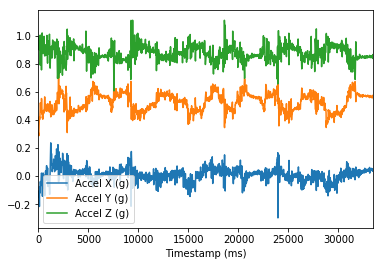

In [15]:
rawdata = act_dict[task][trial][loc][sensor]
idx = rawdata.index
idx = idx-idx[0]
rawdata.index = idx
rawdata.plot()

## HP Filter raw accelerometer data

In [16]:
HPfilter(act_dict,task=task,loc=loc)

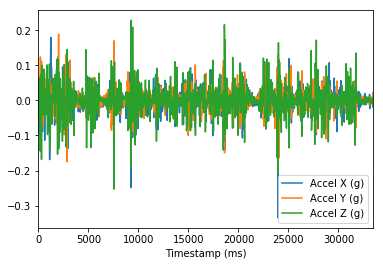

In [17]:
act_dict[task][0][loc][sensor].plot()

## Clip extraction

In [18]:
clip_data = gen_clips(act_dict,task=task,clipsize=10000,location=loc,overlap=0,verbose=True)

Motor #8: Typing on a Computer  sensortype = accel - trial 0
Motor #8: Typing on a Computer  sensortype = gyro - trial 0
Motor #8: Typing on a Computer  sensortype = accel - trial 1
Motor #8: Typing on a Computer  sensortype = gyro - trial 1
Motor #8: Typing on a Computer  sensortype = accel - trial 2
Motor #8: Typing on a Computer  sensortype = gyro - trial 2
Motor #8: Typing on a Computer  sensortype = accel - trial 3
Motor #8: Typing on a Computer  sensortype = gyro - trial 3
Motor #8: Typing on a Computer  sensortype = accel - trial 4
Motor #8: Typing on a Computer  sensortype = gyro - trial 4
Motor #8: Typing on a Computer  sensortype = accel - trial 5
Motor #8: Typing on a Computer  sensortype = gyro - trial 5
Motor #8: Typing on a Computer  sensortype = accel - trial 6
Motor #8: Typing on a Computer  sensortype = gyro - trial 6


In [19]:
clip_data[0][sensor]['clip_len']

[9993, 9977, 9993]

## Feature extraction

Let's start with the following:
* Energy (total within segment)
* Max
* Min
* Mean
* Variance
* Skewness
* Kurtosis
* Power spectra 0-10 Hz

In [20]:
#feature calculation test
# E = np.asarray(np.sum(rawdata**2,axis=0))
# mean = np.asarray(np.mean(rawdata,axis=0))
# var = np.asarray(np.std(rawdata,axis=0))
# sk = skew(rawdata)
# kurt = kurtosis(rawdata)
# min_xyz = np.min(rawdata,axis=0)
# max_xyz = np.max(rawdata,axis=0)
# r = np.asarray(max_xyz-min_xyz)
        
# xfft = np.asarray([Pxx.iloc[:,0].values,Pxx.iloc[:,1].values,Pxx.iloc[:,2].values])
# xfft = np.reshape(xfft,(1,xfft.size)) #row vector
# xfft = xfft.reshape(-1)

# x = np.concatenate((E,r,mean,var,sk,kurt,xfft))
# x.shape

** Plot power spectra from one clip **

In [21]:
nb = 11 #number of bins for power spectra

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000FF30780>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000000137C3D68>], dtype=object)

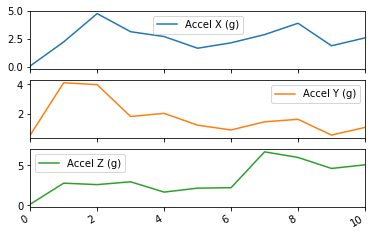

In [22]:
rawdata = clip_data[0][sensor]['data'][0] #trial-sensor-clip#
Pxx,fft_labels = powerspectra(rawdata,0,10,nbins=nb,binavg=True) #dataframe with power spectra for each axis
Pxx.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D8819E8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000C7A1CC0>], dtype=object)

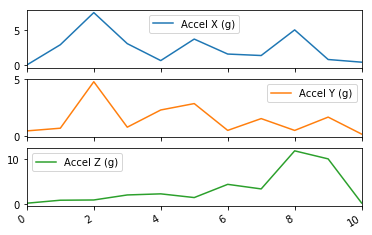

In [23]:
rawdata = clip_data[0][sensor]['data'][0] #trial-sensor-clip#
Pxx,fft_labels = powerspectra(rawdata,0,10,nbins=nb,binavg=False) #dataframe with power spectra for each axis
Pxx.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000CCFD3C8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000C6E7EB8>], dtype=object)

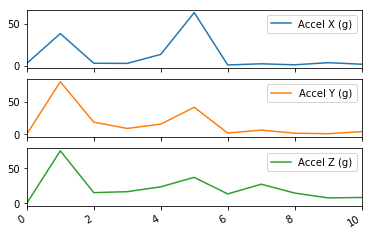

In [24]:
rawdata = clip_data[4][sensor]['data'][0] #trial-sensor-clip#
Pxx,fft_labels = powerspectra(rawdata,0,10,nbins=nb,binavg=False) #dataframe with power spectra for each axis
Pxx.plot(subplots=True)

## Compute Power spectra with Welch method

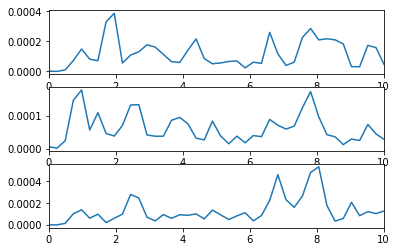

In [25]:
#signal features
rawdata = clip_data[0][sensor]['data'][0] #trial-sensor-clip#
fig = plt.figure()
# fp, ax_arr = plt.subplots(3, sharex=True)

for i in range(3):
    fig.add_subplot(3,1,i+1)
    x = rawdata.iloc[:,i]
    n = len(x) #number of samples in clip
    Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
    f,Pxx_den = welch(x,Fs,nperseg=256)
    plt.plot(f,Pxx_den)
#     plt.semilogy(f,Pxx_den)
    plt.xlim([0,10])

In [26]:
feature_extraction(clip_data)

In [27]:
clip_data[1]['accel']['features']

,EX,EY,EZ,rangeX,rangeY,rangeZ,meanX,meanY,meanZ,varX,...,fftZ1,fftZ2,fftZ3,fftZ4,fftZ5,fftZ6,fftZ7,fftZ8,fftZ9,fftZ10
0,2.492604,5.287570,5.602376,0.656561,0.647910,0.720397,-0.001119,-0.001151,0.001090,0.063092,...,29.215368,17.416115,21.110237,14.543828,12.512177,13.833070,15.815588,7.540504,14.656173,9.739958
1,4.475067,6.418530,7.996640,0.791605,0.748772,1.059913,0.000578,-0.000241,-0.000245,0.084615,...,10.735360,22.936245,29.555632,24.409422,32.564285,11.444315,21.182915,21.056515,14.256378,13.351076
2,4.892190,7.148577,8.951258,0.958148,0.833706,0.924468,-0.000266,-0.000038,-0.000098,0.088402,...,13.800907,13.309106,26.181589,44.079311,43.802773,14.892297,14.625857,36.882427,30.255257,10.073484


## Aggregate features data with scores for given task - cycle through all subjects
for s in subjects:
*    load score files
*    load subject file
*    choose task and sensor location
*    extract clips
*    compute features on each trial
*    Aggregate subj code and score with feature matrix

**Note: gyro data has to be added **

In [29]:
#define task and sensor location
task = 'Motor #8: Typing on a Computer'
task_scores = 'Typing on a computer keyboard' #the task name in the scores file
loc = 'dorsal_hand_right'

#load subject scores
mot_scores = pd.read_excel(os.path.join(scores_path, 'MotorTasks.xls'))
#remove words:(Qxx) and 'rating' from each column for readability
cols= mot_scores.columns
cols = cols[4:]
cols = cols.tolist()
colsnew = [x.split('(')[0] for x in cols]
colsnew = [x.strip() for x in colsnew] #remove whitspace
colsnew = [x.split('rating')[0] for x in colsnew]
colsnew = [x.strip() for x in colsnew]
c = dict(zip(cols,colsnew))
mot_scores = mot_scores.rename(index=str, columns=c)

#load subjects features data and assemble with scores/subj metadata
d = os.listdir(dict_path)
fnames = [filename for filename in d if filename.startswith('1')]
print(fnames)

Data = pd.DataFrame() #the table with all data
for subj_filename in fnames:

    #extract current subject scores and metadata
    subj = int(subj_filename[:4]) #subj code
    subj_score = mot_scores.loc[mot_scores['Subject']==subj,['Subject','Visit',
                                task_scores+ ' ' + 'bradykinesia right upper limb',
                                task_scores+ ' ' + 'tremor right upper limb',
                                task_scores+ ' ' + 'bradykinesia left upper limb',
                                task_scores+ ' ' + 'tremor left upper limb']]
    subj_score = subj_score.rename(index=str,columns=
                                   {subj_score.columns[2]:'Bradykinesia right',subj_score.columns[3]:'Tremor right', 
                                 subj_score.columns[4]:'Bradykinesia left',subj_score.columns[5]:'Tremor left' })
    subj_score.index = range(len(subj_score))
    if len(subj_score) < 1:
        print('no scores data for subject %d -- skipping..'%subj)
 
    #load subject sensor data Pickle file (dictionary)
    else:
        f = open(os.path.join(dict_path,subj_filename),'rb')    
        act_dict = pickle.load(f)
        f.close()
        print('\nLoaded Subj %s sensor data'%subj)
        
        #high pass filter accelerometer data
        HPfilter(act_dict,task,loc)

        #generate clips and extract features
        clip_data = gen_clips(act_dict,task=task,location=loc,overlap=0)
        feature_extraction(clip_data)
        
        #aggreagate subject, scores and features data
        n_visits = len(subj_score)    #of visits in Database
        n_rec = len(clip_data.keys()) #of sensor recordings
        print('n_visits = %d, # recordings = %d'%(n_visits,n_rec))
        N = n_visits

        if n_visits != n_rec:
            print('# of recordings does not match # of visits! - matching first %d recordings'%(min([n_visits,n_rec])))
            N = min([n_visits,n_rec])

        #aggregate data from each visit for current subject
        for i in range(N):
            #features
            D = clip_data[i]['accel']['features']
            featcols = D.columns.tolist()
            #scores
            D['Bradykinesia right'] = subj_score['Bradykinesia right'][i]
            D['Tremor right'] = subj_score['Tremor right'][i]
            D['Bradykinesia left'] = subj_score['Bradykinesia left'][i]
            D['Tremor left'] = subj_score['Tremor left'][i]
            #metadata
            D['Visit'] = subj_score.Visit[i] 
            D['Task'] = task
            D['Location'] = loc 
            D['Subject'] = subj
            Data = pd.concat([Data,D]) #concatenate data from each visit

cols = ['Subject','Visit','Task','Location','Bradykinesia right','Bradykinesia left','Tremor right','Tremor left']+ featcols
Data = Data[cols]    
print('Data matrix generated')
print(Data.shape)

['1004dict.pkl', '1016dict.pkl', '1018dict.pkl', '1019dict.pkl', '1020dict.pkl', '1029dict.pkl', '1044dict.pkl', '1046dict.pkl', '1049dict.pkl']

Loaded Subj 1004 sensor data
n_visits = 7, # recordings = 7

Loaded Subj 1016 sensor data
n_visits = 7, # recordings = 7

Loaded Subj 1018 sensor data
n_visits = 7, # recordings = 7

Loaded Subj 1019 sensor data
n_visits = 7, # recordings = 7

Loaded Subj 1020 sensor data
n_visits = 1, # recordings = 6
# of recordings does not match # of visits! - matching first 1 recordings

Loaded Subj 1029 sensor data
n_visits = 7, # recordings = 7

Loaded Subj 1044 sensor data
n_visits = 7, # recordings = 7

Loaded Subj 1046 sensor data
n_visits = 6, # recordings = 7
# of recordings does not match # of visits! - matching first 6 recordings

Loaded Subj 1049 sensor data
n_visits = 7, # recordings = 7
Data matrix generated
(409, 56)


In [30]:
subj_score.columns

Index(['Subject', 'Visit', 'Bradykinesia right', 'Tremor right',
       'Bradykinesia left', 'Tremor left'],
      dtype='object')

In [31]:
Data.head()

,Subject,Visit,Task,Location,Bradykinesia right,Bradykinesia left,Tremor right,Tremor left,EX,EY,...,fftZ1,fftZ2,fftZ3,fftZ4,fftZ5,fftZ6,fftZ7,fftZ8,fftZ9,fftZ10
0,1004,2 Weeks: Time 0,Motor #8: Typing on a Computer,dorsal_hand_right,2,2,1,1,0.395429,0.361662,...,1.799600,0.362720,0.145889,0.247879,0.083919,0.528011,0.571199,0.873097,0.524895,0.245802
1,1004,2 Weeks: Time 0,Motor #8: Typing on a Computer,dorsal_hand_right,2,2,1,1,0.496269,0.844215,...,6.147520,0.707969,0.260061,0.319264,0.685494,0.987100,1.153719,0.482269,0.365768,0.086628
2,1004,2 Weeks: Time 0,Motor #8: Typing on a Computer,dorsal_hand_right,2,2,1,1,0.307537,0.292238,...,1.105569,0.259662,0.310453,0.364613,0.249013,0.540336,0.498797,0.473921,0.469153,0.194187
3,1004,2 Weeks: Time 0,Motor #8: Typing on a Computer,dorsal_hand_right,2,2,1,1,0.218604,0.175683,...,0.448685,0.094488,0.021901,0.076295,0.093001,0.335031,0.524485,0.380038,0.215248,0.057627
4,1004,2 Weeks: Time 0,Motor #8: Typing on a Computer,dorsal_hand_right,2,2,1,1,0.231803,0.669448,...,3.602953,0.507600,0.152774,0.292162,0.204048,0.183842,0.122911,0.300517,0.234147,0.344637


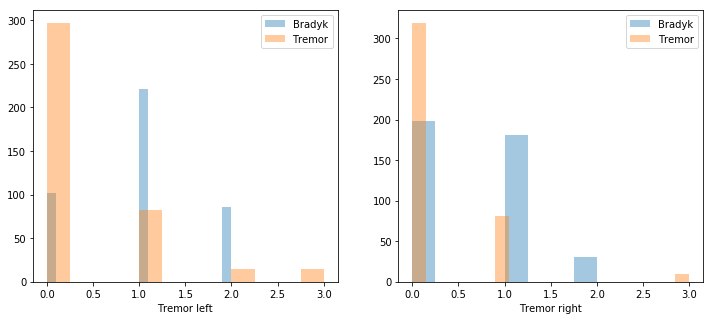

In [32]:
fig = plt.figure(figsize=(12,5))
fig.add_subplot(121)
sns.distplot(Data['Bradykinesia left'],kde=False)
sns.distplot(Data['Tremor left'],kde=False)
plt.legend(['Bradyk','Tremor'])
fig.add_subplot(122)
sns.distplot(Data['Bradykinesia right'],kde=False)
sns.distplot(Data['Tremor right'],kde=False)
plt.legend(['Bradyk','Tremor'])


# PCA on features to visualize subjects with bradykinesia


In [33]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

In [34]:
#rows with symptoms
indp = (Data['Bradykinesia left']>0) | (Data['Bradykinesia right']>0)
indp = indp.astype(int) #1 = w bradykinesia
indp = indp.values
indp = indp.astype('bool')

In [35]:
#standardize features
X = Data.iloc[:,8:]
X_std = StandardScaler().fit_transform(X)
print(X.shape)

(409, 48)


total explained variance ratio (first 10 components): 0.745
[ 0.35017301  0.10917707  0.05882445  0.04906717  0.03854786  0.03382854
  0.03077766  0.02595964  0.02488367  0.02408444]


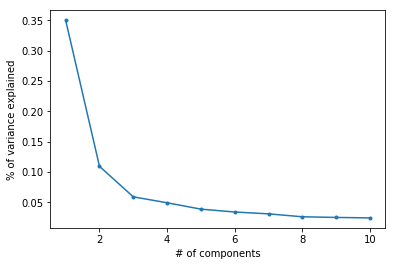

In [36]:
nC = 10
pca = PCA(n_components=nC)
Xpca = pca.fit(X_std).transform(X_std)
# Percentage of variance explained for each components
print('total explained variance ratio (first %d components): %.3f'%(nC, pca.explained_variance_ratio_[0:nC].sum()))
print(pca.explained_variance_ratio_[:10])
plt.plot(range(1,nC+1),pca.explained_variance_ratio_,'.-')
plt.xlabel('# of components')
plt.ylabel('% of variance explained')

In [37]:
Xpca.shape

(409, 10)

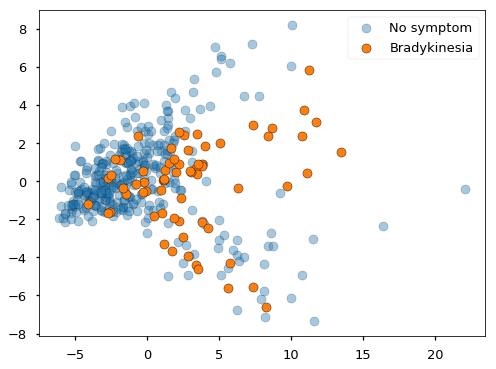

In [38]:
sns.set_context('talk')
fig = plt.figure(figsize=(8,6))
plt.scatter(Xpca[indp,0],Xpca[indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.4,label='No symptom')
plt.scatter(Xpca[~indp,0],Xpca[~indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=1,label='Bradykinesia')
plt.legend()

# Fit an LDA to the data

In [39]:
lda = LinearDiscriminantAnalysis()
#TO COMPLETE

## Tests on individual subjects / features

In [41]:
#load subject scores
#path = '../Scores/'
mot_scores = pd.read_excel(os.path.join(scores_path, 'MotorTasks.xls'))

In [42]:
mot_scores[mot_scores['Subject']==1016].head(3)

,Site,Subject,Visit,CRF#,Data Collected (Qa),Date of assessment (Qb),What is the participants state (Q02),On which hand is the subject wearing the Apple watch (Q03),Was the device shaken 5 times up and down prior to beginning the assessment (Q04),Patients Apple watch clock time when the stop watch is turned on (Q146),...,Folding towels tremor left upper limb rating (Q137),Folding towels tremor right upper limb rating (Q138),Was sitting assessed (Q139),Sitting start time (Q140),Sitting end time (Q141),Sitting dyskinesia left upper limb rating (Q142),Sitting dyskinesia right upper limb rating (Q143),Sitting tremor left upper limb rating (Q144),Sitting tremor upper right limb rating (Q145),General Comments (Qc)
6,"Northwestern Memorial Hospital, Chicago, IL",1016,2 Weeks: Time 0,602,Yes,2017-07-13,Off,Left,Yes,09:52:55,...,1,1,Yes,00:14:07,00:14:37,0,0,0,0,NaN
7,"Northwestern Memorial Hospital, Chicago, IL",1016,2 Weeks: Time 30,644,Yes,2017-07-13,Off,Left,Yes,10:44:52,...,1,1,Yes,00:12:13,00:12:43,0,0,0,0,NaN
8,"Northwestern Memorial Hospital, Chicago, IL",1016,2 Weeks: Time 60,646,Yes,2017-07-13,On,Left,Yes,11:41:35,...,1,1,Yes,00:12:26,00:12:56,0,0,0,0,NaN


In [43]:
subj = 1016
#extract scores for corresponding task 
task = 'Motor #8: Typing on a Computer'
loc = 'dorsal_hand_right'

subj=1016
subj_score = mot_scores.loc[mot_scores['Subject']==subj,['Subject','Visit',
#                 'Typing on a computer keyboard overall score (Q92)',
#                 'Typing on a computer keyboard bradykinesia left upper limb rating (Q93)',
#                 'Typing on a computer keyboard tremor left upper limb rating (Q97)',
                'Typing on a computer keyboard bradykinesia right upper limb rating (Q94)',
                'Typing on a computer keyboard tremor right upper limb rating (Q98)']]

subj_score = subj_score.rename(index=str,columns={subj_score.columns[2]:'Bradykinesia right',subj_score.columns[3]:'Tremor right' })
subj_score.index = range(len(subj_score))
subj_score

,Subject,Visit,Bradykinesia right,Tremor right
0,1016,2 Weeks: Time 0,1,0
1,1016,2 Weeks: Time 30,1,0
2,1016,2 Weeks: Time 60,1,0
3,1016,2 Weeks: Time 90,1,0
4,1016,2 Weeks: Time 120,1,0
5,1016,2 Weeks: Time 150,1,0
6,1016,1 Month,2,0


In [44]:
#aggreagate subject, scores and features data
Data = pd.DataFrame()
D = pd.DataFrame()

n_visits = len(subj_score)    # # of visits in Database
n_rec = len(clip_data.keys()) # # of sensor recordings
print('n_visits = %d, # recordings = %d'%(n_visits,n_rec))
N = n_visits

if n_visits != n_rec:
    print('# of recordings does not match # of visits! - matching first %d recordings')%(min([n_visits,n_rec]))
    N = min([n_visits,n_rec])

for i in range(N):
    #features
    D = clip_data[i]['accel']['features']
    featcols = D.columns.tolist()
    #scores
    D['Bradykinesia right'] = subj_score['Bradykinesia right'][i]
    D['Tremor right'] = subj_score['Tremor right'][i]
    #metadata
    D['Visit'] = subj_score.Visit[i] 
    D['Task'] = task
    D['Location'] = loc 
    Data = pd.concat([Data,D]) #concatenate data from each visit
    
Data['Subject'] = subj 
cols = ['Subject','Visit','Task','Location','Bradykinesia right','Tremor right']+ featcols
Data = Data[cols]    
    

n_visits = 7, # recordings = 7


In [45]:
D.columns

Index(['EX', 'EY', 'EZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX', 'meanY',
       'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ', 'kurtX',
       'kurtY', 'kurtZ', 'fftX1', 'fftX2', 'fftX3', 'fftX4', 'fftX5', 'fftX6',
       'fftX7', 'fftX8', 'fftX9', 'fftX10', 'fftY1', 'fftY2', 'fftY3', 'fftY4',
       'fftY5', 'fftY6', 'fftY7', 'fftY8', 'fftY9', 'fftY10', 'fftZ1', 'fftZ2',
       'fftZ3', 'fftZ4', 'fftZ5', 'fftZ6', 'fftZ7', 'fftZ8', 'fftZ9', 'fftZ10',
       'Bradykinesia right', 'Tremor right', 'Bradykinesia left',
       'Tremor left', 'Visit', 'Task', 'Location', 'Subject'],
      dtype='object')

In [46]:
Data_acc = clip_data[0]['accel']['features']
Data_gyr = clip_data[0]['accel']['features']
print(Data_acc.shape,Data_gyr.shape)
Data = pd.concat([Data_acc,Data_gyr],axis=1)
print(Data.shape)

(6, 56) (6, 56)
(6, 112)


# Visualize different tasks

In [47]:
act_dict.keys()

dict_keys(['Heart Rate Variability', 'MDS-UPDRS #1: Finger Tapping', 'MDS-UPDRS #2: Hand Movements', 'MDS-UPDRS #3: Pronation-Supination', 'MDS-UPDRS #4: Toe Tapping', 'MDS-UPDRS #5: Leg Agility', 'MDS-UPDRS #6: Arising from Chair', 'MDS-UPDRS #7: Gait', 'MDS-UPDRS #8: Postural Stability', 'MDS-UPDRS #9: Postural Hand Tremor', 'MDS-UPDRS #10: Kinetic Hand Tremor', 'MDS-UPDRS #11: Rest Tremor', 'Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting', 'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements', 'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts', 'Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels', 'Motor #13: Sitting'])

In [48]:
act_dict['Motor #10: Drinking Water'][0].keys()

dict_keys(['anterior_thigh_left', 'anterior_thigh_right', 'distal_lateral_shank_left', 'distal_lateral_shank_right', 'dorsal_hand_left', 'dorsal_hand_right', 'flexor_digitorum_left', 'flexor_digitorum_right', 'medial_chest', 'sacrum'])

In [49]:
tasks= ['Motor #13: Sitting','Motor #6: Sit to Stand','Motor #2: Walking','Motor #8: Typing on a Computer','Motor #4: Finger to Nose']
trials = [0,5]
# locs = ['dorsal_hand_right','flexor_digitorum_right','sacrum','anterior_thigh_right']
# sensor = ['accel','gyro']

TypeError: Empty 'DataFrame': no numeric data to plot

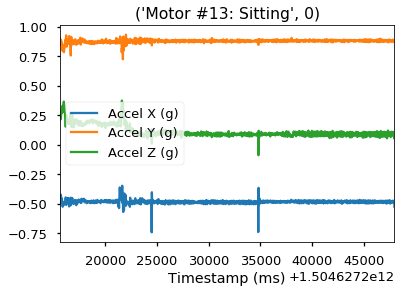

In [50]:
p = product(tasks,trials)
taskslist = list(p)
for t in taskslist:
    plot_data(act_dict,t[0],t[1],'anterior_thigh_right','accel')
    plt.title(t)

In [51]:
#test itertools
from itertools import product
t = ('T1','T2')
l = (1,2)
s = ('s1','s2')
# print(list(product(t,l,s)))
taskslist = list(product(t,l,s))
for t in taskslist:
    print(t)

('T1', 1, 's1')
('T1', 1, 's2')
('T1', 2, 's1')
('T1', 2, 's2')
('T2', 1, 's1')
('T2', 1, 's2')
('T2', 2, 's1')
('T2', 2, 's2')


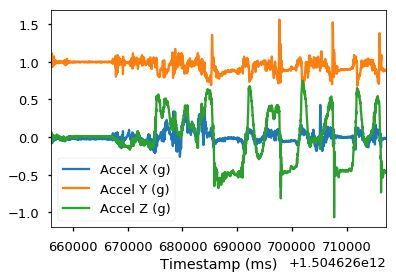

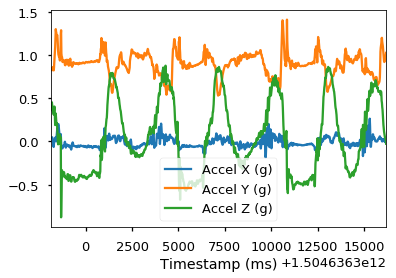

In [52]:
plot_data(act_dict,'Motor #6: Sit to Stand',0,'sacrum','accel')
plot_data(act_dict,'Motor #6: Sit to Stand',5,'sacrum','accel')
# plot_data(act_dict,'Motor #6: Sit to Stand',0,'anterior_thigh_left','accel')
# plot_data(act_dict,'Motor #6: Sit to Stand',5,'anterior_thigh_left','accel')
# plot_data(act_dict,'Motor #6: Sit to Stand',0,'flexor_digitorum_right','accel')
# plot_data(act_dict,'Motor #6: Sit to Stand',5,'flexor_digitorum_right','accel')


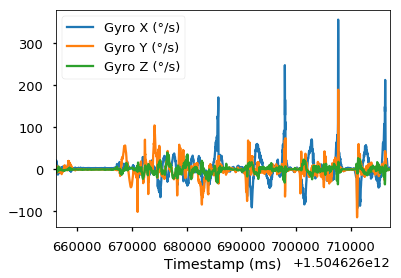

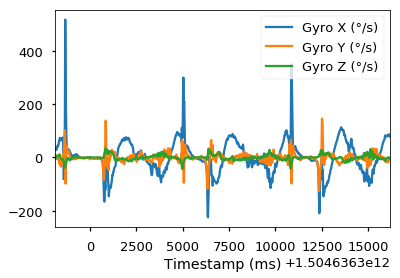

In [53]:
plot_data(act_dict,'Motor #6: Sit to Stand',0,'sacrum','gyro')
plot_data(act_dict,'Motor #6: Sit to Stand',5,'sacrum','gyro')
# plot_data(act_dict,'Motor #6: Sit to Stand',0,'anterior_thigh_left','gyro')
# plot_data(act_dict,'Motor #6: Sit to Stand',5,'anterior_thigh_left','gyro')
# plot_data(act_dict,'Motor #6: Sit to Stand',0,'flexor_digitorum_right','gyro')
# plot_data(act_dict,'Motor #6: Sit to Stand',5,'flexor_digitorum_right','gyro')

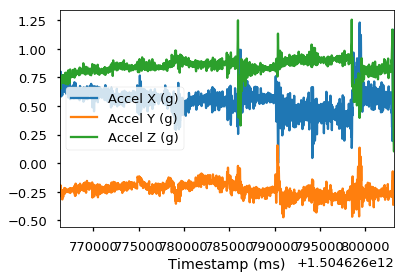

In [54]:
# Subject 1020 - OFF
plot_data(act_dict, 'Motor #7: Drawing on Paper', 0, 'dorsal_hand_right', 'accel')

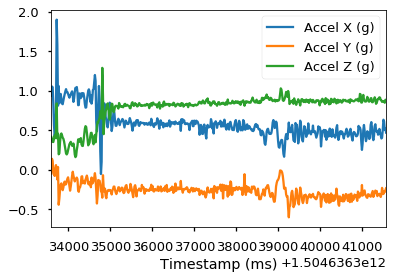

In [55]:
# Subject 1020 - ON
plot_data(act_dict, 'Motor #7: Drawing on Paper', 5, 'dorsal_hand_right', 'accel', 100, 600)

In [56]:
SubID2 = '1029'

act_dict2, timestamps2, testInfo2 = extract_data(SubID2, os.path.join(path, SubID2))

FileNotFoundError: File b'../Scores/1029\\annotations.csv' does not exist

In [57]:
# Subject 1029 - OFF
plot_data(act_dict2, 'Motor #8: Typing on a Computer', 0, 'dorsal_hand_right', 'accel')

NameError: name 'act_dict2' is not defined

In [58]:
# Subject 1029 - ON
plot_data(act_dict2, 'Motor #8: Typing on a Computer', 5, 'dorsal_hand_right', 'accel')

NameError: name 'act_dict2' is not defined

In [59]:
def fix_absent(df, error_df, testInfo):
    Day1 = testInfo.loc[testInfo['Day'] == 'DAY 1', 'Date']
    Day2 = testInfo.loc[testInfo['Day'] == 'DAY 2', 'Date']


In [60]:
timestamps2.loc['Motor #6: Sit to Stand']

NameError: name 'timestamps2' is not defined

In [ ]:
path3 = r'C:\Users\andre\Documents\PD Study Data'
errors = fix_errors(timestamps2, SubID2, path3)
errors

In [ ]:
timestamps.loc['MDS-UPDRS #11: Rest Tremor']

In [ ]:
errors = fix_errors(timestamps, SubID, path3)
errors

In [ ]:
error_df = errors.loc[errors['Error'] == 'Absent']
for i in range(0, int(error_df['Activity'].count())):
    columns = ['EventType', 'Start Timestamp (ms)', 'Stop Timestamp (ms)', 'Cycle']
    name = error_df.iloc[i]['Activity']
    cycle = error_df.iloc[i]['Cycle']
    temp_df = pd.DataFrame([name, 'NaN', 'NaN', cycle], index=columns).T.set_index('EventType')
    timestamps = timestamps.append(temp_df)
timestamps